In [89]:
import os
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [90]:
path = 'Data' #modify path of file directory as appropriate
items = os.listdir(path)
list_of_paths = []

for a in items:
    list_of_paths.append(path + '/' + a)

In [91]:
def process(path): 
    """Processes path into dataframe"""
    ld = pd.read_csv(path)
    df = ld.iloc[:,:3]
    old_column = ld.columns[:3]

    df = df.rename(columns = {old_column[0]:'datetime', old_column[1]:'water_level', old_column[2]: 'is_high_tide'})
    
    df['river'] = path.split('/')[1].split('.')[0]
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['water_level'] = pd.to_numeric(df['water_level'], errors= 'ignore').astype(float)
    df['month'] = df['datetime'].dt.month
    df['year'] = df['datetime'].dt.year
    return df

def pd_analyse_water_levels(path):
    """This function takes in the file path of a csv
    perfoms analysis with pandas
    Columns in the csv are Date and time, water_levels, 
    flag which is a categorical variable 1 or 0
    """

    df = process(path)

    df_high_tide = df[df["is_high_tide"] == 1]['water_level']
    df_low_tide = df[df["is_high_tide"] == 0]['water_level']
    summary_statistics = {'tide_high': {'mean':round(df_high_tide.mean(),2), 
                'median':round(df_high_tide.median(),2), 
                'interquartile_range':round((df_high_tide.quantile(.75) - df_high_tide.quantile(.25)),2)},
    'tide_low': {'mean':round(df_low_tide.mean()), 
                'median':round(df_low_tide.median(),2), 
                'interquartile_range':round((df_low_tide.quantile(.75) - df_low_tide.quantile(.25)),2)}}

    # Calculate ratio of high tide days
    all_high_days = df.query('is_high_tide==1').groupby('year').count()['water_level']
    high_days = df.query(f'(water_level>{df_high_tide.quantile(.75)}) & (is_high_tide==1)').groupby('year').count()['water_level']
    high_ratio = (high_days/all_high_days).reset_index()

    # Calculate ratio of low tide days
    all_low_days = df.query('is_high_tide==0').groupby('year').count()['water_level']
    low_days = df.query(f'(water_level<{df_low_tide.quantile(.25)}) & (is_high_tide==0)').groupby('year').count()['water_level']
    low_ratio = (low_days/all_low_days).reset_index()

    solution = {'river': path.split('/')[1].split('.')[0],'summary_statistics':summary_statistics, 'high_ratio': high_ratio, 'low_ratio':low_ratio}
    new = high_ratio.join(low_ratio, lsuffix = '_low_ratio')
    new.to_excel('{}_levels.xlsx'.format(path.split('/')[1].split('.')[0]))
    print(solution)
    

In [92]:
for path in list_of_paths:
    pd_analyse_water_levels(path)

{'river': '10-11_London_Bridge', 'summary_statistics': {'tide_high': {'mean': 3.32, 'median': 3.35, 'interquartile_range': 0.74}, 'tide_low': {'mean': -2, 'median': -2.41, 'interquartile_range': 0.54}}, 'high_ratio':     year  water_level
0   1911     0.032787
1   1912     0.127469
2   1913     0.186846
3   1914     0.161572
4   1915     0.219219
..   ...          ...
80  1991     0.252125
81  1992     0.265912
82  1993     0.317597
83  1994     0.357447
84  1995     0.324823

[85 rows x 2 columns], 'low_ratio':     year  water_level
0   1911     0.203463
1   1912     0.192793
2   1913     0.102985
3   1914     0.141618
4   1915     0.139818
..   ...          ...
80  1991     0.312057
81  1992     0.265912
82  1993     0.252496
83  1994     0.252482
84  1995     0.246809

[85 rows x 2 columns]}
{'river': '15_Richmond', 'summary_statistics': {'tide_high': {'mean': 3.72, 'median': 3.76, 'interquartile_range': 0.77}, 'tide_low': {'mean': 0, 'median': 0.04, 'interquartile_range': 1.04}}, '

MAKE INTO TIMESERIES FORECASTING

In [93]:
list_of_df = []

for path in list_of_paths:
    list_of_df.append(process(path))
    river_df = pd.concat(list_of_df,axis = 0)

river_df

,datetime,water_level,is_high_tide,river,month,year
0,1911-01-05 15:40:00,3.7130,1,10-11_London_Bridge,1,1911
1,1911-02-05 11:25:00,-2.9415,0,10-11_London_Bridge,2,1911
2,1911-02-05 16:05:00,3.3828,1,10-11_London_Bridge,2,1911
3,1911-03-05 11:50:00,-2.6367,0,10-11_London_Bridge,3,1911
4,1911-03-05 16:55:00,2.9256,1,10-11_London_Bridge,3,1911
...,...,...,...,...,...,...
5282,1918-04-28 15:30:00,3.5004,1,13_Temple_Pier,4,1918
5283,1918-04-29 10:35:00,-2.0111,0,13_Temple_Pier,4,1918
5284,1918-04-29 16:00:00,3.6274,1,13_Temple_Pier,4,1918
5285,1918-04-30 10:45:00,-1.9349,0,13_Temple_Pier,4,1918


In [94]:
london_bridge_df = process(list_of_paths[0])
london_bridge_df

,datetime,water_level,is_high_tide,river,month,year
0,1911-01-05 15:40:00,3.7130,1,10-11_London_Bridge,1,1911
1,1911-02-05 11:25:00,-2.9415,0,10-11_London_Bridge,2,1911
2,1911-02-05 16:05:00,3.3828,1,10-11_London_Bridge,2,1911
3,1911-03-05 11:50:00,-2.6367,0,10-11_London_Bridge,3,1911
4,1911-03-05 16:55:00,2.9256,1,10-11_London_Bridge,3,1911
...,...,...,...,...,...,...
115498,1995-12-30 20:44:00,3.2900,1,10-11_London_Bridge,12,1995
115499,1995-12-31 02:32:00,-1.6000,0,10-11_London_Bridge,12,1995
115500,1995-12-31 08:59:00,3.2000,1,10-11_London_Bridge,12,1995
115501,1995-12-31 15:03:00,-1.8000,0,10-11_London_Bridge,12,1995


In [100]:
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType,BooleanType,DateType,FloatType,StringType

In [131]:
spark = SparkSession.builder.getOrCreate()
df = spark.read.csv(list_of_paths[0], header = True)

new_columns = ['datetime', "water_level","is_high_tide", "not_needed"]
for col,new in zip(df.columns,new_columns):  
    df = df.withColumn(new, df[col])
    df = df.drop(col)
    df = df.drop("not_needed")

In [132]:
df.show()

+-------------------+-----------+------------+
|           datetime|water_level|is_high_tide|
+-------------------+-----------+------------+
|01/05/1911 15:40:00|     3.7130|           1|
|02/05/1911 11:25:00|    -2.9415|           0|
|02/05/1911 16:05:00|     3.3828|           1|
|03/05/1911 11:50:00|    -2.6367|           0|
|03/05/1911 16:55:00|     2.9256|           1|
|04/05/1911 12:10:00|    -2.4843|           0|
|04/05/1911 17:45:00|     3.1542|           1|
|05/05/1911 06:30:00|     3.0780|           1|
|05/05/1911 13:00:00|    -2.4843|           0|
|06/05/1911 07:35:00|     2.7732|           1|
|06/05/1911 14:25:00|    -1.9509|           0|
|07/05/1911 09:10:00|     2.6208|           1|
|07/05/1911 15:30:00|    -2.0271|           0|
|08/05/1911 10:25:00|     2.6716|           1|
|08/05/1911 16:50:00|    -2.1033|           0|
|09/05/1911 12:00:00|     3.0018|           1|
|09/05/1911 18:05:00|    -2.2303|           0|
|10/05/1911 07:00:00|    -2.6367|           0|
|10/05/1911 1

In [133]:
df = df.withColumn("Date", F.split('datetime', " ").getItem(0))
df = df.withColumn("Timeofday", F.split('datetime', " ").getItem(1))
df = df.withColumn("Timeofday", F.split('Timeofday', ":").getItem(0))
df = df.withColumn("Timeofday", F.when(df['Timeofday']>= 12, 1)\
                                .when(df['Timeofday']< 12,0))
#Timeofday corresponds to when reading was taken - Afternoon :1, morning : 0
df = df.drop("datetime")
df.show()

+-----------+------------+----------+---------+
|water_level|is_high_tide|      Date|Timeofday|
+-----------+------------+----------+---------+
|     3.7130|           1|01/05/1911|        1|
|    -2.9415|           0|02/05/1911|        0|
|     3.3828|           1|02/05/1911|        1|
|    -2.6367|           0|03/05/1911|        0|
|     2.9256|           1|03/05/1911|        1|
|    -2.4843|           0|04/05/1911|        1|
|     3.1542|           1|04/05/1911|        1|
|     3.0780|           1|05/05/1911|        0|
|    -2.4843|           0|05/05/1911|        1|
|     2.7732|           1|06/05/1911|        0|
|    -1.9509|           0|06/05/1911|        1|
|     2.6208|           1|07/05/1911|        0|
|    -2.0271|           0|07/05/1911|        1|
|     2.6716|           1|08/05/1911|        0|
|    -2.1033|           0|08/05/1911|        1|
|     3.0018|           1|09/05/1911|        1|
|    -2.2303|           0|09/05/1911|        1|
|    -2.6367|           0|10/05/1911|   

In [134]:
def conv_season(a:int):
    month_to_season = {1:'winter',2:'winter', 3:'spring', 4: 'spring', 5:'spring', 
    6:'summer', 7:'summer', 8: 'summer', 9: 'autumn', 10: 'autumn', 11:'autumn',
    12:'winter' }
    return month_to_season[a]

In [135]:

df = df.withColumn('year', F.split("Date", "/").getItem(2).cast(IntegerType()))\
    .withColumn('month', F.split('Date', '/').getItem(1).cast(IntegerType()))\
    .withColumn('water_level', df['water_level'].cast(FloatType()))\
    .withColumn('is_high_tide', df['is_high_tide'].cast(IntegerType()))\
    .withColumn('Timeofday', df['Timeofday'].cast(IntegerType()))

season_udf = F.udf(conv_season, StringType())
df = df.withColumn('season', season_udf(df['month']))

df = df.drop('Date')
df.show()

#Handle month due to numbers as algorithm will malfunction based on this 
#Add other rivers, because there may be relationship between river levels
#Convert season into categorical variables
#modularise for others

+-----------+------------+---------+----+-----+------+
|water_level|is_high_tide|Timeofday|year|month|season|
+-----------+------------+---------+----+-----+------+
|      3.713|           1|        1|1911|    5|spring|
|    -2.9415|           0|        0|1911|    5|spring|
|     3.3828|           1|        1|1911|    5|spring|
|    -2.6367|           0|        0|1911|    5|spring|
|     2.9256|           1|        1|1911|    5|spring|
|    -2.4843|           0|        1|1911|    5|spring|
|     3.1542|           1|        1|1911|    5|spring|
|      3.078|           1|        0|1911|    5|spring|
|    -2.4843|           0|        1|1911|    5|spring|
|     2.7732|           1|        0|1911|    5|spring|
|    -1.9509|           0|        1|1911|    5|spring|
|     2.6208|           1|        0|1911|    5|spring|
|    -2.0271|           0|        1|1911|    5|spring|
|     2.6716|           1|        0|1911|    5|spring|
|    -2.1033|           0|        1|1911|    5|spring|
|     3.00

In [136]:
print("The max year is {} while the minimum year is {}".format(df.agg({'year': 'max'}).collect()[0],df.agg({'year': 'min'}).collect()[0]))

The max year is Row(max(year)=1995) while the minimum year is Row(min(year)=1911)


In [194]:
morning_levels_df = df.filter(df['Timeofday'] == 0)
afternoon_levels_df = df.filter(df['Timeofday'] == 1)
morning_levels_df.show()

+-----------+------------+---------+----+-----+------+
|water_level|is_high_tide|Timeofday|year|month|season|
+-----------+------------+---------+----+-----+------+
|    -2.9415|           0|        0|1911|    5|spring|
|    -2.6367|           0|        0|1911|    5|spring|
|      3.078|           1|        0|1911|    5|spring|
|     2.7732|           1|        0|1911|    5|spring|
|     2.6208|           1|        0|1911|    5|spring|
|     2.6716|           1|        0|1911|    5|spring|
|    -2.6367|           0|        0|1911|    5|spring|
|    -2.7891|           0|        0|1911|    5|spring|
|    -2.7891|           0|        0|1911|    5|spring|
|    -2.7383|           0|        0|1911|    5|spring|
|    -2.6367|           0|        0|1911|    5|spring|
|    -2.5097|           0|        0|1911|    5|spring|
|    -2.4081|           0|        0|1911|    5|spring|
|    -2.3065|           0|        0|1911|    5|spring|
|    -1.9001|           0|        0|1911|    5|spring|
|      2.3

<AxesSubplot: xlabel='month', ylabel='water_level'>

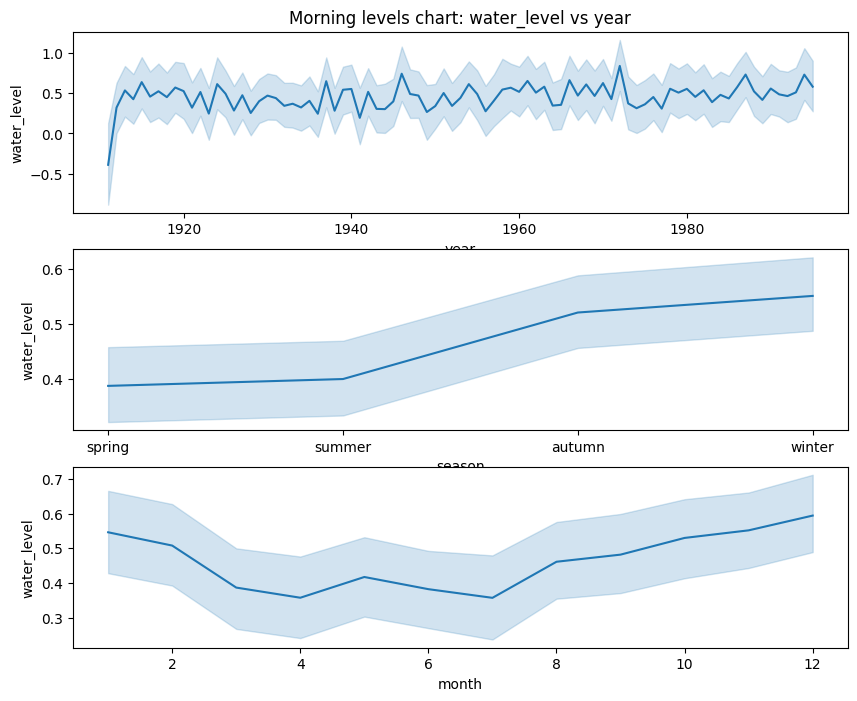

In [196]:
temp = morning_levels_df.sample(False, 0.5, 42).toPandas()

#sns.lineplot(data = temp, y ="water_level", x = "year")
fig,ax = plt.subplots(3,1, figsize = (10,8))
ax[0].set_title("Morning levels chart: water_level vs year")

sns.lineplot(data = temp, y = 'water_level', x  = 'year', ax = ax[0])
sns.lineplot(data = temp, y = 'water_level', x  = 'season', ax = ax[1])
sns.lineplot(data = temp, y = 'water_level', x  = 'month', ax = ax[2])


<AxesSubplot: xlabel='month', ylabel='water_level'>

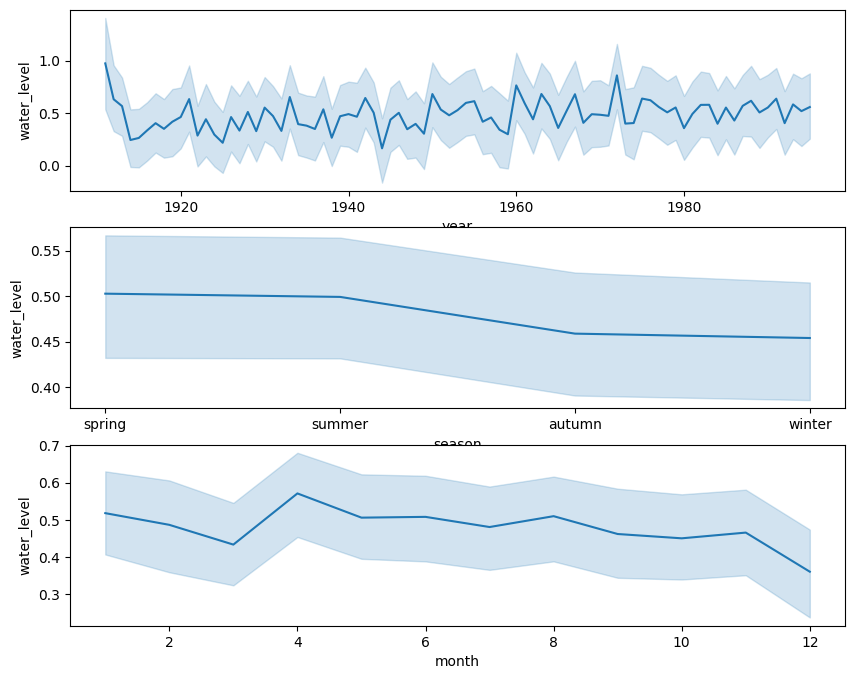

In [202]:
temp_2 = afternoon_levels_df.sample(False, 0.5, 42).toPandas()

fig,ax = plt.subplots(3,1, figsize = (10,8))

sns.lineplot(data = temp_2, y = 'water_level', x  = 'year', ax = ax[0])
sns.lineplot(data = temp_2, y = 'water_level', x  = 'season', ax = ax[1])
sns.lineplot(data = temp_2, y = 'water_level', x  = 'month', ax = ax[2])

In [137]:
train_df = df.filter(df['year'] < 1970)
test_df = df.filter(df['year'] > 1970)

print(train_df.count()/df.count())
train_df.show()

0.6855925820108568
+-----------+------------+---------+----+-----+------+
|water_level|is_high_tide|Timeofday|year|month|season|
+-----------+------------+---------+----+-----+------+
|      3.713|           1|        1|1911|    5|spring|
|    -2.9415|           0|        0|1911|    5|spring|
|     3.3828|           1|        1|1911|    5|spring|
|    -2.6367|           0|        0|1911|    5|spring|
|     2.9256|           1|        1|1911|    5|spring|
|    -2.4843|           0|        1|1911|    5|spring|
|     3.1542|           1|        1|1911|    5|spring|
|      3.078|           1|        0|1911|    5|spring|
|    -2.4843|           0|        1|1911|    5|spring|
|     2.7732|           1|        0|1911|    5|spring|
|    -1.9509|           0|        1|1911|    5|spring|
|     2.6208|           1|        0|1911|    5|spring|
|    -2.0271|           0|        1|1911|    5|spring|
|     2.6716|           1|        0|1911|    5|spring|
|    -2.1033|           0|        1|1911|    5

/var/folders/3v/kl4z85b17kd84k1hy0srlb3w0000gn/T/ipykernel_29619/2082310132.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(temp['water_level'], ax = ax[1])


<AxesSubplot: xlabel='water_level', ylabel='Density'>

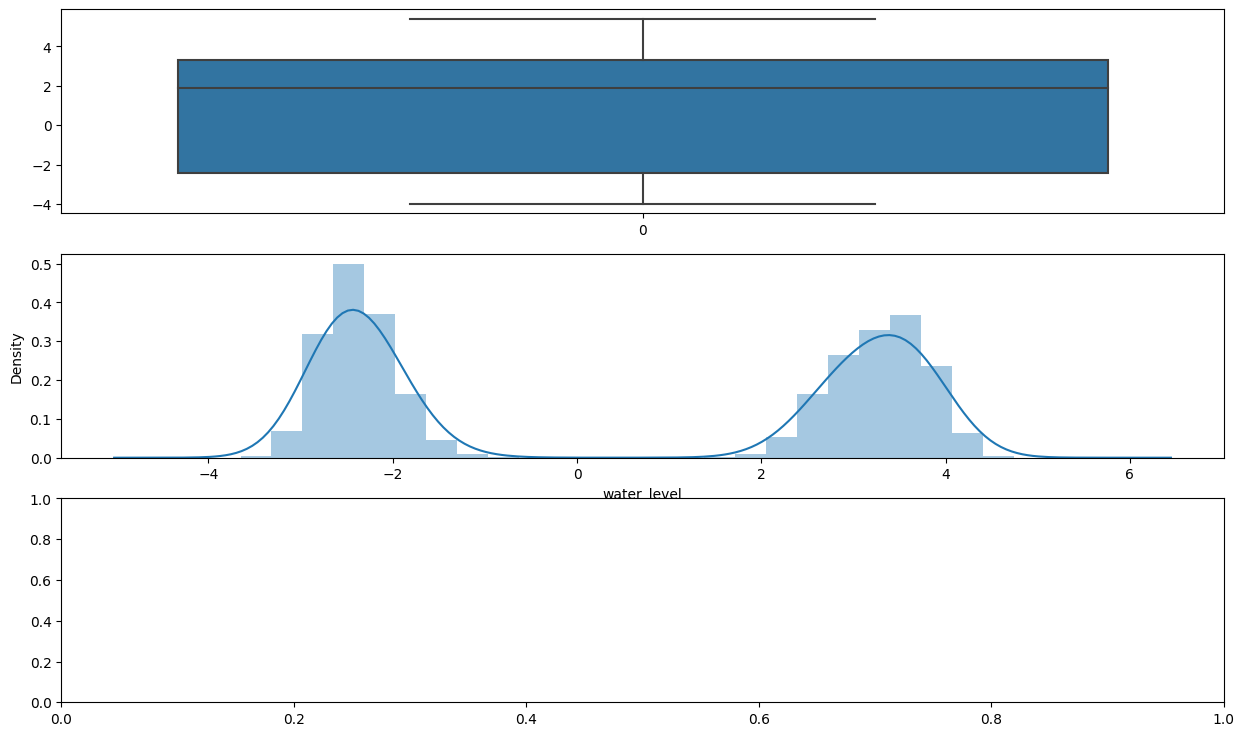

In [139]:
temp = train_df.sample(False, 0.5, 42).toPandas()
fig,ax = plt.subplots(3,1,figsize = (15,9))

sns.boxplot(temp['water_level'], ax = ax[0])
sns.distplot(temp['water_level'], ax = ax[1])

TypeError: regplot() got an unexpected keyword argument 'hue'